In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from pydrake.all import (DiagramBuilder, DynamicProgrammingOptions, FittedValueIteration, 
                         PeriodicBoundaryCondition, SceneGraph, Simulator,WrapToSystem,
                         StartMeshcat, ConnectMeshcatVisualizer)

In [2]:
from pydrake.examples.acrobot import AcrobotGeometry, AcrobotPlant, AcrobotParams
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess

In [4]:
def acrobot_swingup_example():
    plant = AcrobotPlant()
    context = plant.CreateDefaultContext()
    plant_params = plant.get_parameters(context)
    plant_params.set_b1(0)
    plant_params.set_b2(0)
    simulator = Simulator(plant)
    options = DynamicProgrammingOptions()
    n_mesh = 41
    q1bins = np.linspace(0., 2. * np.pi, n_mesh)
    q2bins = np.linspace(-np.pi/2, np.pi/2, int(n_mesh/2))
    qdotbins = np.linspace(-3., 3., int(n_mesh/2))
    state_grid = [set(q1bins), set(q2bins), set(qdotbins), set(qdotbins)]
    options.periodic_boundary_conditions = [
        PeriodicBoundaryCondition(0, 0., 2. * np.pi),
    ]
    options.discount_factor = .999
    input_limit = 3.
    input_grid = [set(np.linspace(-input_limit, input_limit, 9))]
    timestep = 0.01
    
    def quadratic_regulator_cost(context):
        x = context.get_continuous_state_vector().CopyToVector()
        x[0] = x[0] - np.pi
        u = plant.EvalVectorInput(context, 0).CopyToVector()
        return 2 * x.dot(x) + u.dot(u)

    cost_function = quadratic_regulator_cost
    options.convergence_tol = 0.1
    policy, cost_to_go = FittedValueIteration(simulator, cost_function,
                                              state_grid, input_grid, timestep,
                                              options)
    J = np.reshape(cost_to_go, (n_mesh, int(n_mesh/2), int(n_mesh/2), int(n_mesh/2)))
    # np.save("pendulum_swingup/data/acrobot/J_mesh_{}".format(n_mesh), J)

    # plot_surface(meshcat, 'Cost-to-go', Q1, Q2, J[:, :, 0, 0], wireframe=True)
    fig = plt.figure(figsize=(9, 4))
    ax1, ax2 = fig.subplots(1, 2)
    ax1.set_xlabel("q1")
    ax1.set_ylabel("q2")
    ax1.set_title("Cost-to-Go")
    ax2.set_xlabel("q1")
    ax2.set_ylabel("q2")
    ax2.set_title("Policy")
    im1 = ax1.imshow(J[:, :, 0, 0],
               cmap=cm.jet, aspect='auto',
               extent=(q1bins[0], q1bins[-1], q2bins[-1], q2bins[0]))
    ax1.invert_yaxis()
    fig.colorbar(im1)
    Pi = np.reshape(policy.get_output_values(), (n_mesh, int(n_mesh/2), int(n_mesh/2), int(n_mesh/2)))
    im2 = ax2.imshow(Pi[:, :, 0, 0],
               cmap=cm.jet, aspect='auto',
               extent=(q1bins[0], q1bins[-1], q2bins[-1], q2bins[0]))
    ax2.invert_yaxis()
    fig.colorbar(im2)
    plt.show()
    plt.savefig("acrobot_optimal_cost_to_go.png")
    return policy, cost_to_go

In [5]:
def simulate(policy):
    # Animate the resulting policy.
    builder = DiagramBuilder()
    plant = AcrobotPlant()
    context = plant.CreateDefaultContext()
    plant_params = plant.get_parameters(context)
    plant_params.set_b1(0)
    plant_params.set_b2(0)
    acrobot = builder.AddSystem(plant)
    wrap = builder.AddSystem(WrapToSystem(4))
    wrap.set_interval(0, 0, 2*np.pi)
    builder.Connect(acrobot.get_output_port(0), wrap.get_input_port(0))
    vi_policy = builder.AddSystem(policy)
    builder.Connect(wrap.get_output_port(0), vi_policy.get_input_port(0))
    builder.Connect(vi_policy.get_output_port(0),
                    acrobot.get_input_port(0))

    # Setup visualization
    scene_graph = builder.AddSystem(SceneGraph())
    AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0),
                                scene_graph)
    proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=[])
    viz = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)
    diagram = builder.Build()
    simulator = Simulator(diagram)
    simulator.get_mutable_context().SetContinuousState([np.pi-0.01, 0.0, 0, 0])
    viz.start_recording()
    simulator.AdvanceTo(5)
    viz.publish_recording()

INFO:drake:Computing transition and cost matrices.
INFO:drake:Done computing transition and cost matrices.
INFO:drake:Running value iteration.
INFO:drake:Value iteration converged to requested tolerance.


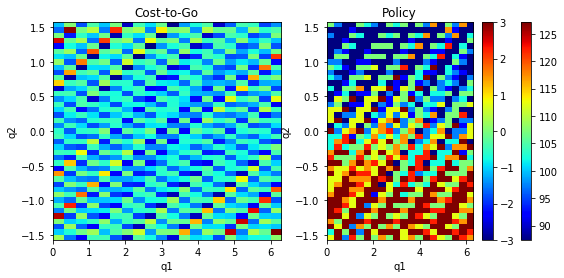

<Figure size 432x288 with 0 Axes>

In [6]:
policy, cost_to_go = acrobot_swingup_example()

In [7]:
print('Simulating...')
simulate(policy)

Simulating...
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6002...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/
Connected to meshcat-server.
